# LendingClub: Predict Loan Charge-Offs and Expected Loan Loss
By **Weixian Wang**


# Table of Contents
1. [Project Description](#1)
2. [Import Libraries](#2)
3. [Data Collection and Pre-Processing](#3)  
    3.1 [Assumptions](#3.1)  
    3.2 [Missing values](#3.2)  
    3.3 [Data Types](#3.3)  
    3.4 [Summary](#3.4)  
4. [Exploratory Data Analysis](#4)
5. [Feature Engineering](#5)
6. [Modeling](#6)  
    6.1 [Pipeline](#6.1)  
    6.2 [Model Training](#6.2)
     * 6.2.1 [Baseline](#6.2.1)  
       6.2.2 [Model-Based Feature Selection](#6.2.2)  
       6.2.3 [Complexity of Features](#6.2.3)  
       6.2.4 [Oversampling with SMOTE](#6.2.4)  
       6.2.5 [Final Model](#6.2.5)  
7. [Business Analysis](#7)  
    7.1 [Business Objective](#7.1)  
    7.2 [Loan Loss Prediction Training](#7.2)  

## 1. Project Description <a id = '1'></a>

LendingClub Corp. is an online lender who makes loans online to consumers and sells the loans to investors. The product is a fixed rate, 3 or 4-year fully amortizing term installment loan.

In this project, we analyze the loan data of LendingClub from the year 2007 to the second quarter in 2019. The data explores the demographic dimensions of personal loans and loan status (fully paid/ charged off), which is available on their website once you create an account.

Our goal is to identify the risk of unsecured personal loans. Specifically, a machine learning model was developed to predict the probability of full payment and charge off.  On top of that, we utilize the model to predict the expected loan loss from current borrowers, providing insights about risk control and loss reduction.

## 2. Import Libraries <a id = '2'></a>

In [1]:
import glob
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)
sns.set(style = 'ticks')
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 122


from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import roc_auc_score, roc_curve,precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Custom transformers
from custom_transformer import Feature_Selector, Convert_LoanAmnt, Convert_Term, Convert_IntR, \
Convert_Home, Credit_Length, Convert_FICO, Convert_DTI, Smote
# Custom model training
from model import train_model, plot_roc_curve, plot_precision_recall_curve, plot_learning_curve
# Modification of official class BayesSearchCV due to the'fit_params' issue at sklearn = 0.21.0
from bayesian_optimization import BayesSearchCV

/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



## 3. Data Collection and Pre-Processing <a id = '3'></a>

Before loading the datasets into the notebook, unformatted rows of texts in each dataset have been removed. 

In [2]:
path = 'data/'
filenames = glob.glob(path + "*.csv")
filenames

['data/LoanStats_securev1_2018Q4.csv',
 'data/LoanStats_securev1_2018Q2.csv',
 'data/LoanStats_securev1_2018Q3.csv',
 'data/LoanStats_securev1_2018Q1.csv',
 'data/LoanStats_securev1_2019Q1.csv',
 'data/LoanStats_securev1_2019Q2.csv',
 'data/LoanStats_securev1_2012-2013.csv',
 'data/LoanStats_securev1_2017Q1.csv',
 'data/LoanStats_securev1_2017Q2.csv',
 'data/LoanStats_securev1_2017Q3.csv',
 'data/LoanStats_securev1_2017Q4.csv',
 'data/LoanStats_securev1_2016Q2.csv',
 'data/LoanStats_securev1_2016Q3.csv',
 'data/LoanStats_securev1_2015.csv',
 'data/LoanStats_securev1_2016Q1.csv',
 'data/LoanStats_securev1_2014.csv',
 'data/LoanStats_securev1_2016Q4.csv',
 'data/LoanStats_securev1_2007-2011.csv']

In [3]:
# Concatenate all datasets
original_data = pd.concat(map(lambda file: pd.read_csv(file, low_memory=False), filenames))
original_data = original_data.reset_index(drop=True)

In [4]:
original_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,145217616,NaN,10000.0,10000.0,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,145248657,NaN,4000.0,4000.0,4000.0,36 months,23.40%,155.68,E,E1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,145638579,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,145592722,NaN,23000.0,23000.0,23000.0,60 months,20.89%,620.81,D,D4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,144858623,NaN,8000.0,8000.0,8000.0,36 months,23.40%,311.35,E,E1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507485 entries, 0 to 2507484
Columns: 150 entries, id to settlement_term
dtypes: float64(111), object(39)
memory usage: 2.8+ GB


The original data has more than 2.5 million records and 150 features.

### 3.1 Assumptions<a id = '3.1'></a>

`Assumption 1`

In [6]:
original_data['loan_status'].value_counts()

Fully Paid                                             1198006
Current                                                 968807
Charged Off                                             291254
Late (31-120 days)                                       22347
Issued                                                    8713
In Grace Period                                           8475
Late (16-30 days)                                         5497
Does not meet the credit policy. Status:Fully Paid        1988
Default                                                   1634
Does not meet the credit policy. Status:Charged Off        761
Name: loan_status, dtype: int64

**Modeling**: "loan_status" is the `target variable`. Because we are predicting whether the loan would be paid off, we just keep loans with status `'Fully paid'` and `'Charged Off'`. 

**Business Report**: We will use the data with loan_status = `Current` for the purpose of loss prediction.

`Assumption 2`

Next, since we are predicting whether a customer will default, we assume the model should not include features that are generated after the loan issuance. Therefore We go through the [data dictionary](https://www.lendingclub.com/info/download-data.action) by LendingClub to filter out those features.

In [7]:
unwanted_cols = ['member_id','funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'fico_range_high',
                 'out_prncp_inv','total_pymnt', 'title', 'zip_code', 'total_pymnt_inv','total_rec_prncp', 
                 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
                 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high','last_fico_range_low',
                 'collections_12_mths_ex_med', 'hardship_flag', 'debt_settlement_flag', 'mo_sin_old_rev_tl_op'] 

`Assumption 3`

We may not want to keep columns of only one unique values because they do not add useful information to the model.

In [8]:
unique_cols = [col for col in original_data.columns.values if original_data[col].nunique() == 1]
print("Dropped columns:", unique_cols)

Dropped columns: ['policy_code', 'hardship_type', 'deferral_term', 'hardship_length']


`All together`

In [9]:
drop_cols = unwanted_cols + unique_cols
original_data = original_data.drop(columns = drop_cols)

original_data = original_data.loc[original_data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Current'])]
original_data.shape

(2458067, 121)

### 3.2 Missing values<a id = '3.2'></a>

Let us look at the missing value ratio across columns. 

In [10]:
original_data.isnull().mean().sort_values(ascending = False).head(10)

orig_projected_additional_accrued_interest    0.996962
hardship_loan_status                          0.996000
payment_plan_start_date                       0.996000
hardship_reason                               0.996000
hardship_status                               0.996000
hardship_amount                               0.996000
hardship_start_date                           0.996000
hardship_last_payment_amount                  0.996000
hardship_payoff_balance_amount                0.996000
hardship_end_date                             0.996000
dtype: float64

In [11]:
missing_data = pd.DataFrame(original_data.isnull().mean().sort_values(ascending = False)).reset_index()
missing_data.columns = ['Column', 'Missing Value Ratio']

Here we are going to **drop out columns with missing value ratio greater than 0.3**, consisuting 32% of features.

In [12]:
missing_cols = (missing_data.loc[missing_data['Missing Value Ratio'] >= 0.3, ['Column']])
missing_cols.head(10)

,Column
0,orig_projected_additional_accrued_interest
1,hardship_loan_status
2,payment_plan_start_date
3,hardship_reason
4,hardship_status
5,hardship_amount
6,hardship_start_date
7,hardship_last_payment_amount
8,hardship_payoff_balance_amount
9,hardship_end_date


In [13]:
original_data = original_data.drop(columns = missing_cols.Column)
original_data.shape

(2458067, 67)

### 3.3 Data Types<a id = '3.3'></a>

In this section we check every feature and suggest necessary dtype transformations based on the defintions. 
And more importantly, we have reduced the memory usuage of dataframe by **73%** by:  
* Downcasting float64 to float32**
* Converting object to category**

By going through the data dictionary, we found the dtype of certain features need to be converted.  
First, we would convert object type 'int_rate' and 'revol_util' to `float` type .

In [14]:
original_data[['int_rate', 'revol_util']] = original_data[['int_rate', 'revol_util']].apply(
                                                lambda x: x.str.rstrip('%').astype('float'))

Then we would convert object type 'issue_d' to `datatime` type.

In [15]:
# Add a leading zero to the issue date at 2009 or earlier
original_data['issue_d'] = original_data['issue_d'].apply(lambda x: '0'+x if not x.startswith('1') else x)
original_data['issue_d'] = pd.to_datetime(original_data['issue_d'], format = '%y-%b')
original_data['issue_year'] = original_data['issue_d'].dt.year

In [16]:
original_data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458067 entries, 0 to 2504732
Data columns (total 68 columns):
id                            object
loan_amnt                     float64
term                          object
int_rate                      float64
installment                   float64
grade                         object
sub_grade                     object
emp_title                     object
emp_length                    object
home_ownership                object
annual_inc                    float64
verification_status           object
issue_d                       datetime64[ns]
loan_status                   object
purpose                       object
addr_state                    object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line              object
fico_range_low                float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal         

The dataframe is using **3 GB of memory**. Currently there are 54 features with float64 type, 13 features with object types, 1 feature with datetime type and int64 respectively. We are going to **reduce the memory usuage** of the dataframe by changing the dtypes.

In [17]:
def memory_usage(pd):
    '''
    Calculate the memory usuage of pandas dataframe.
    
    Parameters:
        pd: pandas dataframe
        
    Returns:
        The memory usuage of dataframe in MB
    '''
    
    memory_usuage = pd.memory_usage(deep=True).sum()
    usage_MB = memory_usuage / 1024 ** 2
    return "{:.2f} MB".format(usage_MB)

**`float64 -> float32`** 

In [18]:
original_data_float = original_data.select_dtypes(include = ['float'])
downcast_float = original_data_float.apply(pd.to_numeric,downcast = 'float')
print('Memory usuage of original float columns:', memory_usage(original_data_float))
print('Memory usuage of downcast float columns:',memory_usage(downcast_float))

Memory usuage of original float columns: 993.94 MB
Memory usuage of downcast float columns: 506.35 MB


Here the memory usuage of float columns **reduces by 49%**.

**`object -> category`**

Let us take a look at the description of features with object type.

In [19]:
original_data.describe(include = ['O'])

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,earliest_cr_line,initial_list_status,application_type
count,2458067,2458067,2458067,2458067,2257958,2292520,2458067,2458067,2458067,2458067,2458067,2458067,2458067,2458067
unique,2458067,2,7,35,535324,11,6,3,3,14,51,762,2,2
top,83886078,36 months,B,C1,Teacher,10+ years,MORTGAGE,Source Verified,Fully Paid,debt_consolidation,CA,9/4/2019,w,Individual
freq,1,1746246,722945,156072,42410,807584,1212280,960701,1198006,1384649,341350,16812,1716389,2307720


We can see that unique values makes up far less than 50% in every feature. We think it is safe to convert the object type to category type.

In [20]:
original_data_obj = original_data.select_dtypes(include = ['object'])
convert_obj = pd.DataFrame()

for col in original_data_obj.columns:
    convert_obj.loc[:, col] = original_data_obj[col].astype('category')

print('Memory usuage of original object columns:', memory_usage(original_data_obj))
print('Memory usuage of converted object columns:',memory_usage(convert_obj))

Memory usuage of original object columns: 2098.65 MB
Memory usuage of converted object columns: 293.38 MB


The memory usage of object columns has been **reduced by an impressive 86%**.

**`All Together`**

Next we will create a copy of original dataframe and replace float64 columns with `float32` columns and object columns with `category` columns.

In [21]:
new_data = original_data.copy()
new_data[downcast_float.columns] = downcast_float
new_data[convert_obj.columns] = convert_obj

print('Memory usuage of original dataframe:', memory_usage(original_data))
print('Memory usuage of new dataframe:', memory_usage(new_data))

Memory usuage of original dataframe: 3111.35 MB
Memory usuage of new dataframe: 818.48 MB


We have made great progress! The memory usage of the dataframe **declined to 811.38 MB with a 73% downsizing**.

### 3.4 Summary<a id = '3.4'></a>

In [22]:
# dataframe for the modeling next
df = new_data.loc[new_data['loan_status'].isin(['Fully Paid', 'Charged Off'])].drop(columns = ['id', 'out_prncp', 'issue_d'])

# dataframe for business analysis                                              
business_data = new_data.loc[new_data['loan_status'] == 'Current'].reset_index(drop = True)

In [23]:
# Pickle the datafram if necessary
#df.to_pickle("df.pkl")
#business_data.to_pickle("business_data.pkl")

In [24]:
# delete unwanted dataframes
del original_data, original_data_float, downcast_float, original_data_obj, convert_obj, new_data

## 4. Exploratory Data Analysis<a id = '4'></a>

Here we select a few important features.

**`loan_status`**  
Current status of the loan.

In [25]:
df['loan_status'].value_counts()

Fully Paid     1198006
Charged Off     291254
Current              0
Name: loan_status, dtype: int64

We could see that the distribution of **target feature is imbalanced** where "Fully paid" makes up 80% of loan status. We may want to **oversample on 'Charged off'** later before model training. Also, we would **choose AUC , precision and recall** over accuracy when it comes to the model performance evaluation.

**`loan_amnt`**  
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

Text(0.5, 1.0, 'Distribution of Loan Amount')

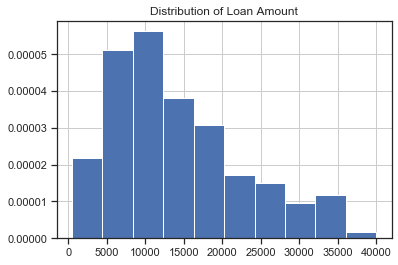

In [26]:
df['loan_amnt'].hist(density = True)
plt.title('Distribution of Loan Amount')

Loan amount with the largest population are USD10,000, 5000 and 15000.

**`dti`**  
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [27]:
df['dti'].describe()

count    1.488718e+06
mean     1.836339e+01
std      1.180910e+01
min     -1.000000e+00
25%      1.180000e+01
50%      1.764000e+01
75%      2.413000e+01
max      9.990000e+02
Name: dti, dtype: float64

In [28]:
df['dti'].quantile(np.arange(0, 1, 0.099))

0.000    -1.000000
0.099     7.220000
0.198    10.430000
0.297    12.950000
0.396    15.250000
0.495    17.530001
0.594    19.879999
0.693    22.459999
0.792    25.490000
0.891    29.450001
0.990    38.790001
Name: dti, dtype: float32

In [29]:
(df['dti'] >40).mean()

0.00610773135651263

99% of borrowers having dti less than 40, which is good. Borrowers with dti greater than 40 only make up 0.6% of population. Notice that the highest dti is 999.

**`term`**  
The number of payments on the loan. Values are in months.

In [30]:
df['term'].value_counts()

 36 months    1124329
 60 months     364931
Name: term, dtype: int64

We have either a 36-month or 60-month term. So we will treat it as a categorical feature.

**`purpose`**  
A category provided by the borrower for the loan request. 

In [31]:
purpose = df[['purpose', 'loan_amnt']].groupby('purpose', as_index = False).sum().sort_values('loan_amnt', ascending = False)
total_loan = purpose['loan_amnt'].sum()
purpose['% of Loan Amount'] = purpose['loan_amnt'].map(lambda x: '{:.2f}'.format(100 * x / total_loan)).astype('float')

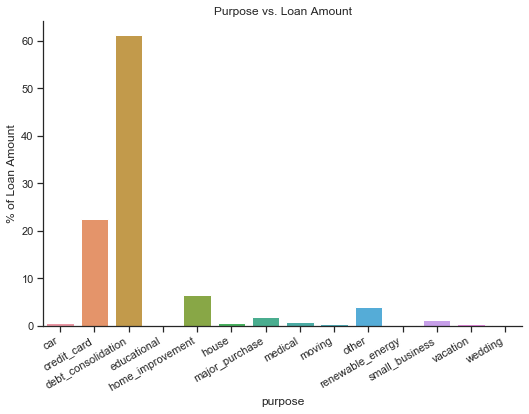

In [32]:
sns.catplot(x = "purpose", y = "% of Loan Amount",kind = 'bar', aspect=1.5, data = purpose).set_xticklabels(rotation=30, ha='right')
plt.title('Purpose vs. Loan Amount')
plt.show()

Over 60% of total loan amount are used to consolidate debt. This is easy to understand because its interest rate used to be lower. Next come to credit card paidofff and home improvement, representing 22.53% and 6.44% respectively.

**`loan_amnt`**

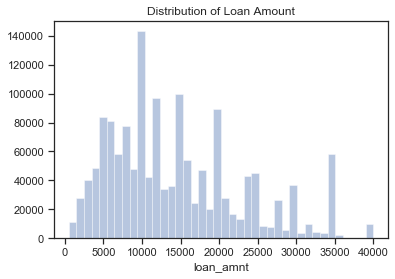

In [33]:
sns.distplot(df['loan_amnt'], kde = False, bins = 40).set_title('Distribution of Loan Amount')
plt.show()

The loan amount distribution is right skewed with the greatest amount equal to 40k. Most of loans lie in between 5k and 15k. Also, we could see that 36-month loan is prefeerable to 60-month's, especially for the loan amount less than 10k.  
Next we are going to see how loan volume change over year.  


**`credit score vs. loan_status`**

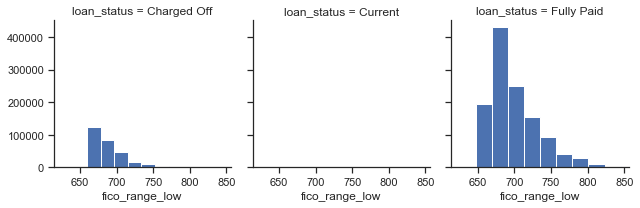

In [34]:
fico_loan = df.loc[:, ['fico_range_low', 'loan_status']]

g = sns.FacetGrid(fico_loan, col = "loan_status")
g = g.map(plt.hist, "fico_range_low")

The most 'charged off' and 'fully paid' both occur in fico between 650 and 700. The distributions for 'charged off" and 'Fully Piad" are similar where the former has a heavier right tail.

**`grade vs. loan_status`**

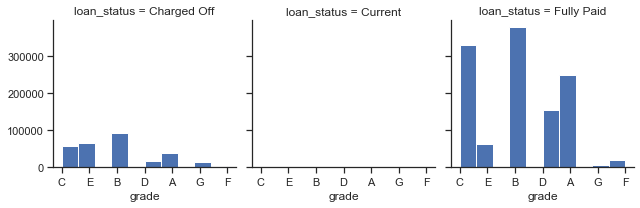

In [35]:
grade_loan = df.loc[:, ['grade', 'loan_status']]

g = sns.FacetGrid(grade_loan, col = "loan_status")
g = g.map(plt.hist, "grade")

All loans are graded by [LendingClub](https://www.lendingclub.com/foliofn/rateDetail.action) where A is the best grade. The loan grade takes into account not only credit score, but also a combination of several indicators of credit risk from the credit report and loan application. Consequently, **people with high grade will be able to borrow at a lower interest rate**. Vice versa.  

We could observe that majority of people who fully paid off the loan are those who are **graded A, B and C**. However, those whose debt has been charged off are less likely to be grade A or B customer. Instead **B, C and E** seem more common.

**`pub_rec_bankruptcies vs. loan_status`**

In [36]:
df[['pub_rec_bankruptcies', 'loan_status']].groupby('loan_status').sum()

,pub_rec_bankruptcies
loan_status,
Charged Off,44962.0
Current,0.0
Fully Paid,155117.0


There are significantly more public record bankruptcies in the 'charged off' group. But what is interesting is 155117 borrowers with such record were still issued loans. Probably the online lending is less strict than we thought.

**`Correlations between the predictor features and target features`**

Here are the feature pairs with pearson correlation >= 0.6. We will drop out features on `level_1`.

In [37]:
corr = df.corr()
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(np.bool))
corr = corr[abs(corr) >= 0.6].stack().reset_index()
corr.head(20)

,level_0,level_1,0
0,loan_amnt,installment,0.952820
1,delinq_2yrs,num_tl_90g_dpd_24m,0.656027
2,open_acc,total_acc,0.703673
3,open_acc,num_actv_rev_tl,0.660882
4,open_acc,num_bc_sats,0.621959
5,open_acc,num_op_rev_tl,0.832411
6,open_acc,num_rev_accts,0.651013
7,open_acc,num_rev_tl_bal_gt_0,0.663138
8,open_acc,num_sats,0.998769
9,pub_rec,pub_rec_bankruptcies,0.644255


## 5. Feature Engineering<a id = '5'></a>

All transformers are encapsulated in `custom_transformer.py`. 

## 6. Modeling<a id = '6'></a>

Following the feature engineering, we will create a complete pipeline. Then we train logistic regression, random forest, and Xgboost models and select the best model.  
Here are the steps:
1. Due to the limit of computing power, we randomly sample 5% of data and feed all features into all three models. Then we choose one of them as the baseline model.
2. With the baseline model, we will perform feature selection using a model-based selector, says LinearSVC, to check the performance.
3. We will increase/decrease the complexity of features if underfitting/overfitting occurs, and re-train the model.
4. We would also try to oversample the data inside the cross-validation to avoid optimistic model performance. Then we would re-train the model.
5. Compared all the models previously and choose the best model. That would be used to implement the business analysis of potential loan loss in the next section.

### 6.1 Pipeline<a id = '6.1'></a>

In [3]:
# feature engineering pipeline
feature_eng_pipe = Pipeline([('Convert_Term', Convert_Term('term')),
                             ('Convert_Home', Convert_Home('home_ownership')),
                             ('Credit_Length', Credit_Length('earliest_cr_line'))
                            ])

# Numeric features
num_cols = ['open_acc','pub_rec', 'revol_bal', 'revol_util', 'acc_now_delinq', 'tot_coll_amt',
            'tot_cur_bal',  'acc_open_past_24mths', 'bc_open_to_buy', 'chargeoff_within_12_mths',
            'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
            'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 
            'num_il_tl',  'num_tl_120dpd_2m',  'mort_acc', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq',
            'pub_rec_bankruptcies', 'total_bal_ex_mort', 'delinq_2yrs']

# Potential polynomial features
num_poly_cols = ['loan_amnt', 'int_rate', 'dti', 'annual_inc', 'fico_range_low','inq_last_6mths',
                 'credit_length']

# Categorical features
cat_cols = ['term','sub_grade', 'emp_length','home_ownership', 'verification_status', 'purpose',
            'addr_state', 'initial_list_status','application_type']

In [4]:
def make_pipe(num_cols, num_poly_cols, cat_cols, poly_features = False):
    '''
    Make a pipeline for numeric features and categorical features.
    
    Parameters:
        num_cols: numeric features
        num_poly_cols: Potential polynomial numeric features
        cat_cols: categorical features
        poly_features: Boolean
        
    Returns:
        A union pipeline
    '''
        
    if poly_features == True:
        num_poly_pipe = Pipeline([('num_poly_selector', Feature_Selector(num_poly_cols)),
                                  ('imputer', SimpleImputer(strategy = 'mean')),
                                  ('polynomial_features', PolynomialFeatures(interaction_only = True)),
                                  ('Normalization', StandardScaler())])
    else:
        num_poly_pipe = Pipeline([('num_poly_selector', Feature_Selector(num_poly_cols)),
                                  ('imputer', SimpleImputer(strategy = 'mean')),
                                  ('Normalization', StandardScaler())])
        
    num_pipe = Pipeline([('num_selector', Feature_Selector(num_cols)),
                         ('imputer', SimpleImputer(strategy = 'mean')),
                         ('Normalization', StandardScaler())])  
    
    cat_pipe = Pipeline([('cat_selector', Feature_Selector(cat_cols)),
                         ('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('ohe', OneHotEncoder(sparse = False, handle_unknown='ignore'))])

    union = FeatureUnion([('num', num_pipe),
                          ('num_poly', num_poly_pipe), 
                          ('cat', cat_pipe)])
    return union


In [40]:
union = make_pipe(num_cols, num_poly_cols, cat_cols)

### 6.2 Model Training<a id = '6.2'></a>

Since the target feature is imbalanced, accuracy is not a good indicator of model performance. We will take a look at precision, recall and AOC-AUC to evaluate the model. Additionaly, we would sample 5% of data for model training.

In [5]:
# Map two loan statuses
df['Charged_off'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off':1})
df = df.drop(columns = ['loan_status'])

In [6]:
# Random state
rs = 0

In [7]:
# sample 5% of data
pct5_df = df.sample(frac = 0.02, replace = False, random_state = rs).reset_index(drop = True)
pct5_df.shape

(29785, 65)

In [8]:
# Split the training data
X = pct5_df.drop('Charged_off', axis = 1)
y = pct5_df['Charged_off']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23828, 64), (5957, 64), (23828,), (5957,))

#### 6.2.1 Baseline<a id = '6.2.1'></a>

**`Logistic Regression`**

In [45]:
clf = LogisticRegression(class_weight = 'balanced', random_state = rs)

full_pipe = Pipeline([('feature_engineering', feature_eng_pipe),
                      ('union', union),
                      ('classifier', clf)])

param_grid =({'classifier__penalty': ['l1', 'l2'],
              'classifier__C': np.logspace(0.001, 10, 5),
              'union__num__imputer__strategy': ['median', 'mean']
              })

In [46]:
lr_model = train_model(full_pipe, param_grid, RandomizedSearchCV, 'Logistic Regression',
                       X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.6s finished
/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



AUC is 0.715361414663943
Training score is 0.7189756899897839
CV score is 0.7067510173036103
Best parameter is {'union__num__imputer__strategy': 'mean', 'classifier__penalty': 'l1', 'classifier__C': 1.0023052380778996}


**`Random Forest`**

In [47]:
clf = RandomForestClassifier(class_weight = 'balanced', random_state = rs)

full_pipe = Pipeline([('feature_engineering', feature_eng_pipe),
                 ('union', union),
                 ('classifier', clf)])

param_grid =({'classifier__n_estimators': [100, 200, 300, 500],
              'classifier__max_depth': [5, 8, 10, 15],
              'classifier__max_leaf_nodes': [10, 60, 100],
              'union__num__imputer__strategy': ['median', 'mean']
              })

In [48]:
rf_model = train_model(full_pipe, param_grid, RandomizedSearchCV, 'Random Forest', 
                       X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


AUC is 0.7133173949215798
Training score is 0.7729639427620699
CV score is 0.7065293870196295
Best parameter is {'union__num__imputer__strategy': 'median', 'classifier__n_estimators': 300, 'classifier__max_leaf_nodes': 100, 'classifier__max_depth': 10}


**`XGBoost`**

You might want to use the BayesSearchCV, which is also imported with modifications with 'fit_params' issue. We turn to RandomizedSearchcv because of its similar auc with less running time.

In [49]:
clf = XGBClassifier(random_state = rs)

full_pipe = Pipeline([('feature_engineering', feature_eng_pipe),
                 ('union', union),
                 ('classifier', clf)])

param_grid = {'classifier__n_estimators': [100, 200, 300, 500],
              'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
              'classifier__max_depth': [3, 5, 8, 10, 12],
              'classifier__min_child_weight': [1, 3, 5, 6, 8],
              'classifier__scale_pos_weight': [4],
              'union__num__imputer__strategy': ['median', 'mean']
             }

In [50]:
xgb_model =train_model(full_pipe, param_grid, RandomizedSearchCV, 'XGBoost', 
                        X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.1min finished


AUC is 0.7120964569961955
Training score is 0.7764892781488554
CV score is 0.705777703047135
Best parameter is {'union__num__imputer__strategy': 'median', 'classifier__scale_pos_weight': 4, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}


We want the highest auc so **logistic regression** appears to be the best model to move forward with. Next, we are trying to use regularization to find optimal coefficients for our **feature selection**.

#### 6.2.2 Model-Based Feature Selection<a id = '6.2.2'></a>

Since it is a binary classfication, we will use linearsvc as the selector and re-train the model.

In [51]:
clf = LogisticRegression(class_weight = 'balanced', random_state = rs)
svc_selector = SelectFromModel(LinearSVC(dual = False))

full_pipe = Pipeline([('feature_engineering', feature_eng_pipe),
                      ('union', union),
                      ('select', svc_selector),
                      ('classifier', clf)])

param_grid =({'classifier__penalty': ['l1', 'l2'],
              'classifier__C': np.logspace(0.001, 10, 5),
              'union__num__imputer__strategy': ['median', 'mean'],
              'select__threshold': [.01, .05, .1, "mean", 'median'],
              'select__estimator__penalty': ['l1', 'l2']
              })

In [52]:
lr_s_model = train_model(full_pipe, param_grid, RandomizedSearchCV, 'lr', 
                         X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.8s finished
/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



AUC is 0.7150616178515045
Training score is 0.7188862330387079
CV score is 0.7061490387811105
Best parameter is {'union__num__imputer__strategy': 'median', 'select__threshold': 0.01, 'select__estimator__penalty': 'l2', 'classifier__penalty': 'l1', 'classifier__C': 10000000000.0}


We could see that feature selections did not help to improve the auc. Additionally, the auc of baseline model 0.7153 indicates underfitting, thus we think there might be repetition in the features. Next we will **increase the complexity of features** to tackle underfitting.

#### 6.2.3 Complexity of Features<a id = '6.2.3'></a>

We are going to add polynomial features into the pipeline and re-train the model.

In [9]:
union = make_pipe(num_cols, num_poly_cols, cat_cols, poly_features = True)

In [10]:
clf = LogisticRegression(class_weight = 'balanced', random_state = rs)

full_pipe = Pipeline([('feature_engineering', feature_eng_pipe),
                      ('union', union),
                      ('classifier', clf)])

param_grid =({'classifier__penalty': ['l1', 'l2'],
              'classifier__C': np.logspace(0.001, 10, 5),
              'union__num__imputer__strategy': ['median', 'mean']
              })

In [11]:
lr_c_model = train_model(full_pipe, param_grid, RandomizedSearchCV, 'Logistic Regression', 
                       X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished
/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



AUC is 0.7174304476832811
Training score is 0.7220081577815123
CV score is 0.7077781630305443
Best parameter is {'union__num__imputer__strategy': 'mean', 'classifier__penalty': 'l1', 'classifier__C': 1.0023052380778996}


Now we have a better auc 0.7174 than the baseline! Let us take a look at the feature importance.

In [12]:
coefs = lr_c_model.named_steps['classifier'].coef_[0]

transformed_num_poly_cols = lr_c_model.named_steps['union'].transformer_list[1][1] \
                                                           .steps[2][1].get_feature_names(num_poly_cols)

transformed_cat_cols = lr_c_model.named_steps['union'].transformer_list[2][1] \
                                                           .steps[2][1].get_feature_names(cat_cols)

features = num_cols + transformed_num_poly_cols + list(transformed_cat_cols)

In [13]:
feature_importance = pd.DataFrame(data = np.abs(coefs), index = features) \
                       .rename(columns = {0: 'Coef'}).sort_values('Coef', ascending = False)
feature_importance.head(20)

,Coef
fico_range_low credit_length,1.509143
credit_length,1.417221
dti,1.290230
annual_inc fico_range_low,1.254658
dti fico_range_low,1.161458
annual_inc,1.135177
sub_grade_A1,0.977445
sub_grade_A2,0.893779
sub_grade_G5,0.847549
sub_grade_A5,0.691967


We could see that **fico, credit length, dti, annual income, interest rate, subgrade, inquiries in last 6 months and their interactions** are the most important features. Before the conclustion that this is the final mode, we would like to **oversample the minor class** to see if the model performance would improve.

#### 6.2.4 Oversampling with SMOTE<a id = '6.2.4'></a>

Because we have imbalanced classes, we are going to **oversample the minor class (0) inside the cross validation** with the model in 6.2.3.

In [14]:
# Transform X before oversampling
X_SMOTE = full_pipe[:-1].fit_transform(X)

In [15]:
skf = StratifiedKFold(n_splits = 5, random_state = rs)
aucs = [] # Store the aucs from the cross validation

for train_index, test_index in skf.split(X_SMOTE, y):
    X_train_ind, X_test_ind = X_SMOTE[train_index], X_SMOTE[test_index]
    y_train_ind, y_test_ind = y[train_index], y[test_index]
    
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train_ind, y_train_ind)
    model = lr_c_model.named_steps['classifier']
    model.fit(X_train_oversampled, y_train_oversampled)  
    y_score_ind = model.predict_proba(X_test_ind)[:, 1]
    auc_ind = roc_auc_score(y_test_ind, y_score_ind)
    aucs.append(auc_ind)
    
print('auc is {}'.format(np.mean(aucs)))

/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/wyattwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence 

auc is 0.7050925226300138


Seems oversampling is not helpful. Now we confirm the final model.

#### 6.2.5 Final Model<a id = '6.2.5'></a>

We would choose the linear regression model in 6.2.3 as the **final model**.

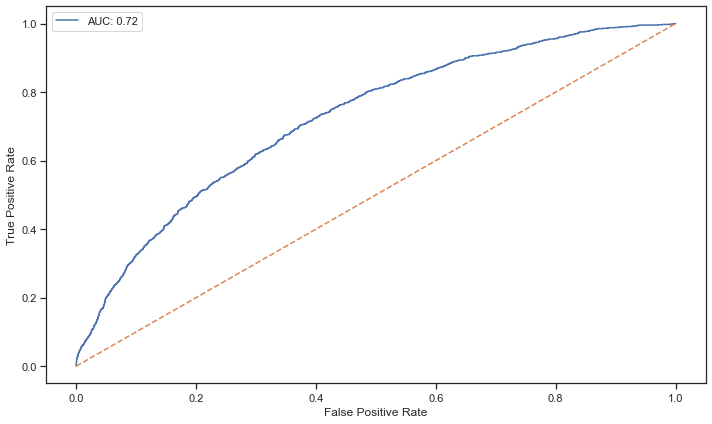

In [16]:
y_score = lr_c_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plot_roc_curve(fpr, tpr, auc)

## 7. Business Analysis<a id = '7'></a>

### 7.1 Business Objective<a id = '7.1'></a>

By applying varying classification thresholds, we can trace out explicitly the trade-off between preicision and recall from the PR curve.

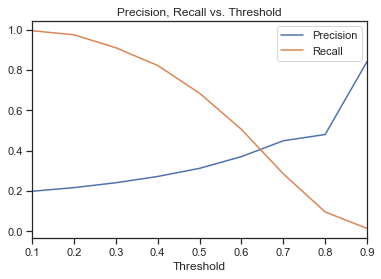

In [17]:
thresholds = np.arange(0.1, 1, 0.1)
plot_precision_recall_curve(y_score, y_test, thresholds)

* Positive: Charge Off
* Negative: Fully Paid
* Precision is defined as `True Positive/(True Positive + False Positive)`.
* Recall is defined as `True Positive/(True Positive + False Negative)`.

At the default threshold 0.5, we have a precision 0.3 and recall 0.65, which means we have a significant number of false positives. In other words, many borrowers who paid off are predicted to have a charge off.  

In the business setting, the threshold is set differently by business objectives.  For example, if LendingClub wants to minimize the loan loss due to charge offs, they may want to lower the threshold to get a good recall score. This would reduce the likelihood that the positive class(charge off) is missed. However, on the other side, the precision score would go down,  resulting in more false positives. That means a growing number of borrowers who paid off are predicted to have a charge off. This would cause the borrowers to have a bad experience with the company. And more importantly, LendingClub would lose the interest income collected from those who are incorrectly classified. Vice versa.

### 7.2 Loan Loss Prediction<a id = '7.2'></a>

By utilizing the machine learning model, we are trying to predict the loan loss for those current borrowers.  

Assume threshold = 0.5.

In [18]:
# We created this dataframe in section 3.4
business_data = pd.read_pickle('business_data.pkl')
business_data.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_year
0,145217616,10000.0,36 months,10.330000,324.230011,B,B1,NaN,< 1 year,MORTGAGE,...,4.0,91.300003,28.6,0.0,0.0,367828.0,61364.0,20900.0,54912.0,2018
1,145248657,4000.0,36 months,23.400000,155.679993,E,E1,Security,3 years,RENT,...,9.0,95.000000,0.0,0.0,0.0,98655.0,66926.0,21900.0,71555.0,2018
2,145592722,23000.0,60 months,20.889999,620.809998,D,D4,Operator,5 years,RENT,...,3.0,100.000000,0.0,0.0,0.0,7500.0,976.0,3300.0,0.0,2018
3,144858623,8000.0,36 months,23.400000,311.350006,E,E1,Manager,10+ years,OWN,...,2.0,100.000000,100.0,1.0,0.0,199744.0,31078.0,2300.0,32206.0,2018
4,145606176,32075.0,60 months,11.800000,710.260010,B,B4,Nursing Supervisor,10+ years,MORTGAGE,...,2.0,100.000000,50.0,0.0,0.0,360433.0,56635.0,20000.0,80125.0,2018


**First** we run the model with business data, and get the probability of charge off for each borrower.

In [19]:
X_business_data = business_data.drop(columns = ['id', 'out_prncp', 'issue_d', 'loan_status'])

In [20]:
# Calculate the probability of charge off for each current borrower
y_score_business_data = lr_c_model.predict_proba(X_business_data)[:, 1]

**Secondly** we are going to use **ECL model** to calculate the expected loan loss.  

`Expected Credit Loss = LGD x PD x EAD`  
The expected loss is calculated as a loan’s LGD multiplied by both its probability of default (PD) and the financial institution’s exposure at default (EAD).

LGD(%): the amount unrecovered by the lender after selling the underlying asset if a borrower defaults on a loan. Because there is no collateral requirement for all of loans in the data, `LGD equals to 1`. 

PD: Probability of default, which is the feauture `y_score_business_data`.  

EAD: Remaining outstanding principal, which is the feature `'out_prncp'`.

In [21]:
PD = pd.DataFrame(y_score_business_data.reshape(-1, 1))
EAD = pd.DataFrame(business_data['out_prncp'])

Expected_Loss = PD.values * EAD.values
Expected_Loss

array([[  812.52974642],
       [ 2797.35873508],
       [15091.2720637 ],
       ...,
       [ 3585.1869059 ],
       [ 4720.52664133],
       [ 4698.9950713 ]])

**As mentioned previously, **fico, credit length, dti, annual income, interest rate, subgrade, inquiries in last 6 months and their interactions** are the essential features of the model. Here we will briefly analyze the expected loan loss based on the model.

In [22]:
business_cols = ['id', 'issue_year', 'loan_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'fico_range_low',
                'addr_state', 'dti']
new_business_data = business_data.loc[:, business_cols]
new_business_data['expected_loss'] = Expected_Loss

new_business_data.head()

,id,issue_year,loan_amnt,term,int_rate,grade,annual_inc,fico_range_low,addr_state,dti,expected_loss
0,145217616,2018,10000.0,36 months,10.330000,B,280000.0,700.0,OR,6.150000,812.529746
1,145248657,2018,4000.0,36 months,23.400000,E,90000.0,730.0,NJ,26.330000,2797.358735
2,145592722,2018,23000.0,60 months,20.889999,D,68107.0,670.0,KS,0.520000,15091.272064
3,144858623,2018,8000.0,36 months,23.400000,E,43000.0,685.0,AL,33.240002,4942.543321
4,145606176,2018,32075.0,60 months,11.800000,B,150000.0,695.0,VA,22.209999,16181.183444


In [30]:
print('We have {} current borrowers totally.'.format(new_business_data.shape[0]))

We have 968807 current borrowers totally.


**`Distribution of Expected Loss`**

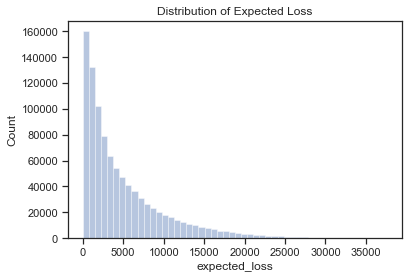

In [24]:
sns.distplot(new_business_data['expected_loss'], kde = False)
plt.title('Distribution of Expected Loss')
plt.ylabel("Count")
plt.show()

In [25]:
new_business_data['expected_loss'].describe()

count    968807.000000
mean       4980.825257
std        5208.927760
min           0.000000
25%        1193.979941
50%        3131.252091
75%        7012.870301
max       37630.978228
Name: expected_loss, dtype: float64

**The mean expected loss is \\$5236.  Over 30% of current borrowers owe less than $2500, while 75% of the population owe less than \\$7386. But we could also see some substantial loss, says \\$30000 or beyond.**

**`grade vs. loan loss`**

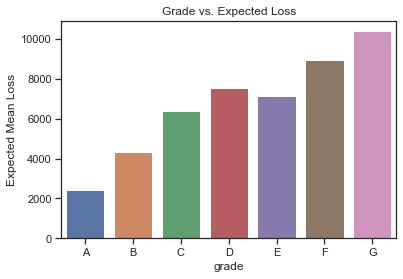

In [26]:
loss_by_grade = new_business_data[['grade', 'expected_loss']].groupby('grade').mean() \
                                                  .sort_values('expected_loss', ascending = False).head(10)

sns.barplot(loss_by_grade.index, loss_by_grade['expected_loss'])
plt.title('Grade vs. Expected Loss')
plt.ylabel("Expected Mean Loss")
plt.show()

**The higher the grade, the less the mean loss, except grade D and E. We would suggest enhancing scrutiny for borrowers with low grades since they are more likely to have charge offs with the greater amount.**

**`term vs. loan loss`**

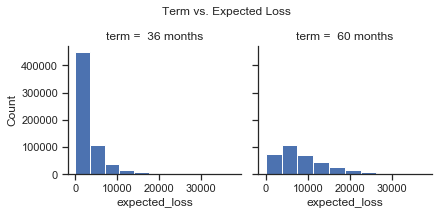

In [27]:
g = sns.FacetGrid(new_business_data, col = 'term')
g.map(plt.hist, 'expected_loss')
g.fig.subplots_adjust(top = 0.8)
plt.suptitle('Term vs. Expected Loss')
g.axes[0,0].set_ylabel('Count')
plt.show()

**We could see 36-month loans have the most charge-offs with the amount less than \\$5000. Regarding the charge-off amount over \$20000, it is more likely to happen for those who applied for 60-month loans. Agian, in addition to more scrutiny on low-graded borrowers, we should also screen shorter-maturity loan.**

**`Loan Loss by State`**

In [28]:
ls_state = new_business_data[['addr_state', 'expected_loss']].groupby('addr_state', as_index = False).sum() \
                                                  .sort_values('expected_loss', ascending = False)
ls_state.columns = ['State', 'Expected Loss']

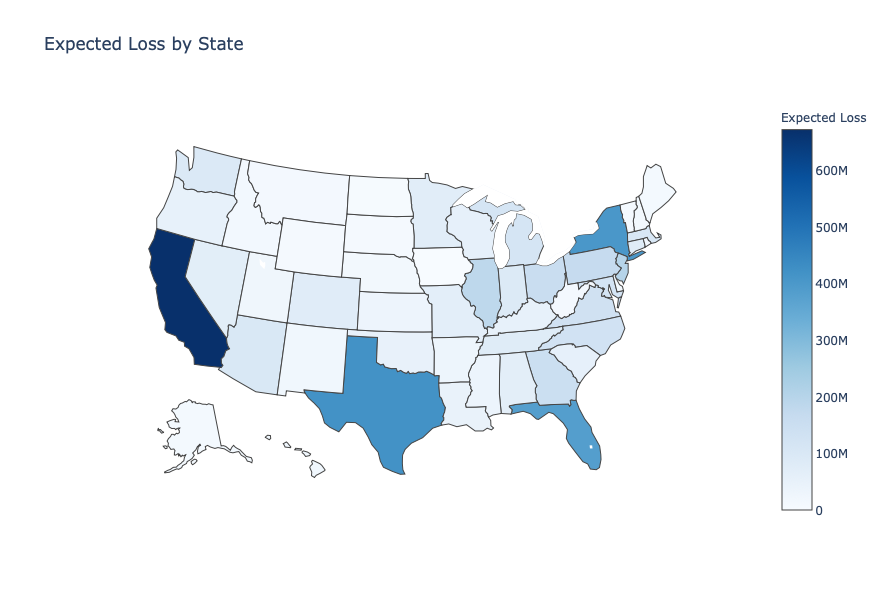

In [29]:
fig = px.choropleth(ls_state, locations = 'State',
                    color = 'Expected Loss', scope = 'usa',
                    locationmode = 'USA-states', title = 'Expected Loss by State',
                    color_continuous_scale = px.colors.sequential.Blues)
fig.show()

**California, New York, and Texas are the top three states with the highest expected loss. We would suggest making significant efforts to collect outstanding payments in these state. Also, it is noticeable that the loss in Iowa is Zero. Literally, it means the loan repayment behavior is excellent. However, further analysis shows that only \\$70000 of loan is issued in Iowa. Probably LendingClub needs to grow more business there.**